# Sanger - Fusion Finder analysis

This Jupyter notebook reproduces the results from the Fusion Finder analysis on the B-ALL dataset, in which we compare the insertions/CTGs identified using Fusion Finder with those from DNA-seq and IM-Fusion analyses.

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

First we read the results from Fusion Finder analysis (which was run externally). For our further analyses, we also annotate these insertions with the transposon features and genes that are overlapped by these insertions.

In [2]:
from nbsupport.util import fetch_biomart_genes_mm10

# Read fusions.
col_names = ['chromosome', 'start', 'end', 'sample', 
             'n_reads', 'n_reads_unique', 'n_reads_total', 'sb_position']

insertions = pd.read_csv('../data/processed/sanger/fusion-finder/fus.txt',
                         sep='\t', header=None, names=col_names)
insertions = insertions.loc[insertions['chromosome'] != '1']

# Annotate with features.
feature_map = {
    'T2onc:0-200': 'IR/DR1',
    'T2onc:450-650': 'SA',
    'T2onc:1400-1600': 'En2SA',
    'T2onc:2000-2200': 'IR/DR2',
    'T2onc:900-1100': 'SD'
}

insertions['sb_feature'] = insertions['sb_position'].map(feature_map)

# Annotate with genes.
mmu_genes = fetch_biomart_genes_mm10()

def _overlapping_genes(row, genes):
    overlap = genes.search(row.chromosome, row.start, row.end)
    return set(overlap['gene_name'])

insertions['genes'] = insertions.apply(
    lambda r: ';'.join(_overlapping_genes(r, mmu_genes)), axis=1)
insertions.ix[insertions['genes'] == '', 'genes'] = np.nan

To determine which candidate genes were identified by Fusion Finder, we rank genes by the frequency of their ocurrence:

In [3]:
(insertions.groupby('genes')
           ['sample'].nunique()
           .sort_values(ascending=False)
           .head(n=15).to_frame('n_sample').head(n=5))

,n_sample
genes,
Cblb,5
Dlx3,2
Sos1,2
Nfrkb,2
Txndc11,1


This shows that, of the candidates previously identified by IM-Fusion/DNA-seq, Fusion Finder only identifies *Cblb* and *Dlx3* recurrently.

One reason that we might be missing the other candidate genes, is that Fusion Finder has problems identifying insertions with that stem from a specific SB feature. This would explain why we are missing *Jak1* (for example), as *Jak1* is mainly affected by SD insertions. 

We can check for this kind of bias by plotting the distribution of SB features:

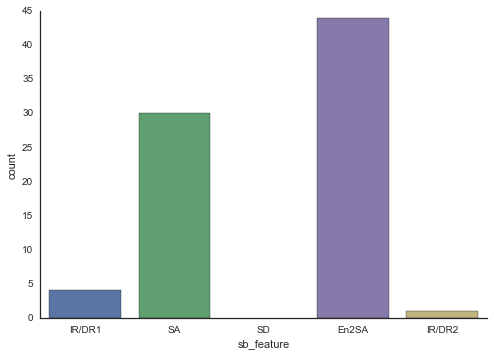

In [4]:
fig, ax = plt.subplots()
sns.countplot(data=insertions, x='sb_feature',
              order=['IR/DR1', 'SA', 'SD', 'En2SA', 'IR/DR2'], ax=ax);
sns.despine()

This shows that Fusion Finder does seem to have an issue identifying insertions that involve the SD feature. Further inspection (not shown here), demonstrates that this is because the reads supporting these fusions are left unmapped by Fusion Finder, whilst they are mapped by fusion-aware aligners such as STAR and Tophat-Fusion.

Finally, to provide an overview of the Fusion Finder insertions (for Supplementary Table S9), we create the following table:

In [5]:
genes = ['Jak1', 'Stat5b', 'Cblb', 'Dlx3', 'Bmi1', 'Zfp423', 'Il2rb', 'Foxp1']
ins_summ = (
    insertions.query('genes == {!r}'.format(genes))
              .sort_values('genes')
              .get(['sample', 'genes', 'chromosome', 'start',
                    'end', 'sb_feature', 'n_reads'])
              .rename(columns={
                  'sample': 'Sample',
                  'chromosome': 'Chromosome',
                  'start': 'Start',
                  'end': 'End',
                  'n_reads': 'Num. reads',
                  'sb_feature': 'Transposon feature',
                  'genes': 'Gene'
              }))

ins_summ

,Sample,Gene,Chromosome,Start,End,Transposon feature,Num. reads
47,TAPJ49_5c,Bmi1,2,18681750,18682050,SA,150
48,TAPJ49_5c,Bmi1,2,18682050,18682350,SA,22
59,TAPJ49_5c,Bmi1,2,18682650,18682950,IR/DR2,10
63,TAPJ52_2a,Cblb,16,52139250,52139550,En2SA,13
109,TAPJ84_3c,Cblb,16,52140750,52141050,En2SA,22
75,TAPJ53_3m,Cblb,16,52142550,52142850,En2SA,109
74,TAPJ53_3m,Cblb,16,52141050,52141350,En2SA,56
73,TAPJ53_3m,Cblb,16,52140750,52141050,En2SA,42
64,TAPJ52_2a,Cblb,16,52139550,52139850,En2SA,68
111,TAPJ84_3c,Cblb,16,52142550,52142850,En2SA,48
